# Basic Examples for the DoE Subpackage

The following example has been taken from the paper "The construction of D- and I-optimal designs for mixture experiments with linear constraints on the components" by R. Coetzer and L. M. Haines. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from bofire.data_models.constraints.api import (
    NonlinearEqualityConstraint,
    NonlinearInequalityConstraint,
    LinearEqualityConstraint,
    LinearInequalityConstraint,
    InterpointEqualityConstraint,
)
from bofire.data_models.domain.api import Domain
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.strategies.doe.design import find_local_max_ipopt

## linear model

In [12]:
domain = Domain(
   inputs = [
    ContinuousInput(key="x1", bounds = (0,1)),
    ContinuousInput(key="x2", bounds = (0.1, 1)),
    ContinuousInput(key="x3", bounds = (0, 0.6))
    ],
   outputs = [ContinuousOutput(key="y")],
   constraints = [
       LinearEqualityConstraint(features=["x1","x2","x3"], coefficients=[1,1,1], rhs=1),
       LinearInequalityConstraint(features=["x1","x2"], coefficients=[5,4], rhs=3.9),
       LinearInequalityConstraint(features=["x1","x2"], coefficients=[-20,5], rhs=-3)
   ]
)

d_optimal_design = find_local_max_ipopt(domain, "linear", n_experiments=12, ipopt_options={"disp":0}).to_numpy().T

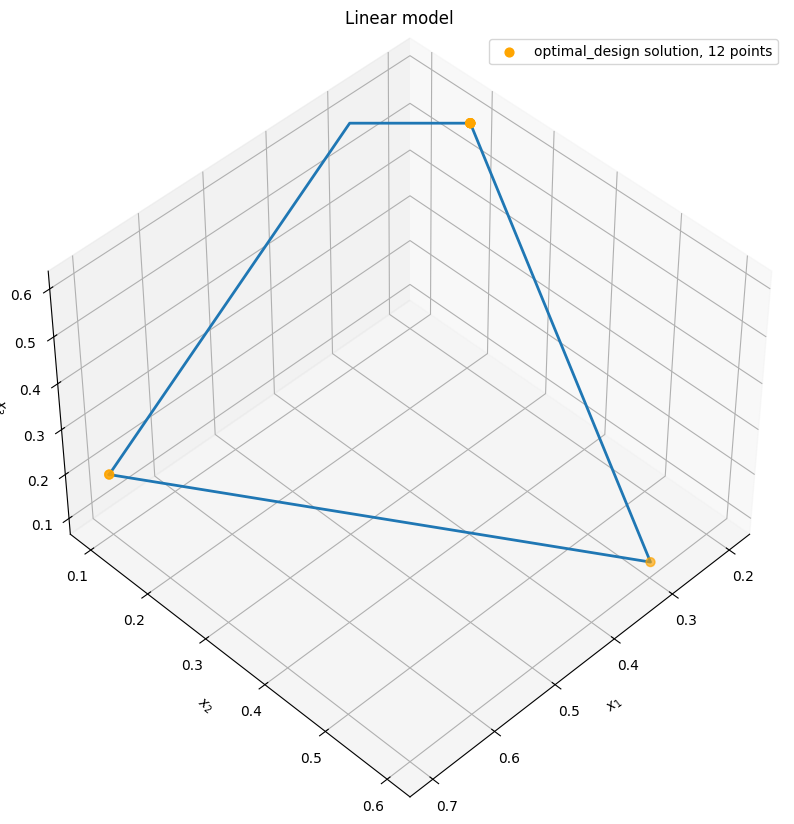

In [13]:
fig = plt.figure(figsize=((10,10)))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, 45)
ax.set_title("Linear model")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.rcParams["figure.figsize"] = (10,8)

#plot feasible polytope
ax.plot(
    xs=[7/10, 3/10, 1/5, 3/10, 7/10],
    ys=[1/10, 3/5, 1/5, 1/10, 1/10],
    zs=[1/5, 1/10, 3/5, 3/5, 1/5],
    linewidth=2
)

#plot D-optimal solutions
ax.scatter(
    xs=d_optimal_design[0],
    ys=d_optimal_design[1],
    zs=d_optimal_design[2],
    marker="o",
    s=40,
    color="orange",
    label="optimal_design solution, 12 points"
)

plt.legend()

## cubic model

/Users/aaron/Documents/bofire/bofire/strategies/doe/design.py:668: UserWarning: The minimum number of experiments is 17, but the current setting is n_experiments=12.
  warnings.warn(


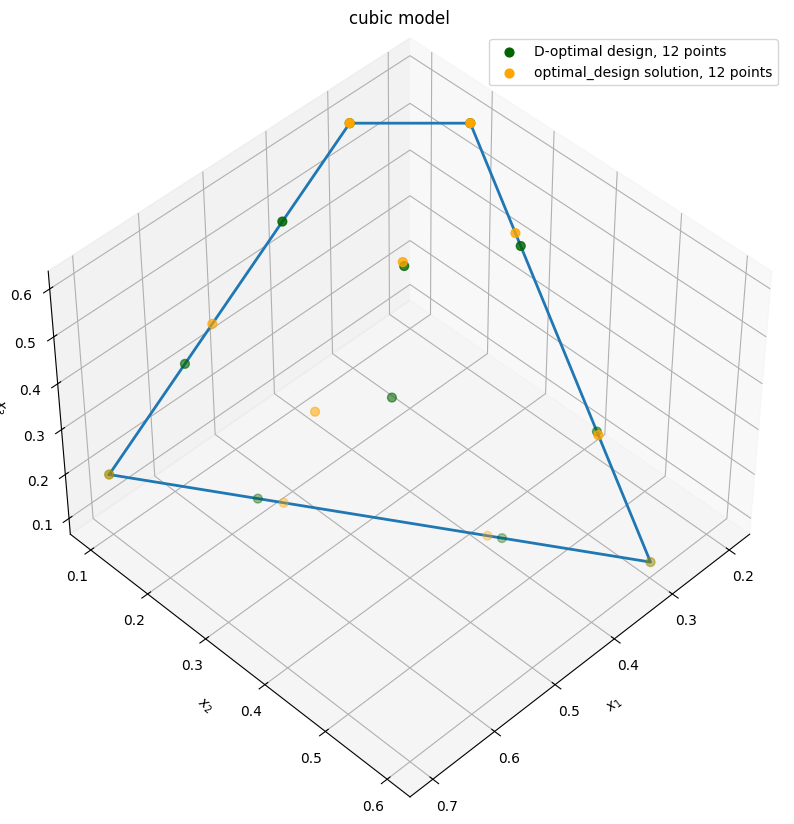

In [14]:
d_optimal_design = find_local_max_ipopt(domain, "x1 + x2 + x3 + {x1**2} + {x2**2} + {x3**2} + {x1**3} + {x2**3} + {x3**3} + x1:x2 + x1:x3 + x2:x3 + x1:x2:x3", n_experiments=12).to_numpy().T

d_opt = np.array([
    [0.7, 0.3, 0.2, 0.3, 0.5902, 0.4098, 0.2702, 0.2279, 0.4118, 0.5738, 0.4211, 0.3360],
    [0.1, 0.6, 0.2, 0.1, 0.2373, 0.4628, 0.4808, 0.3117, 0.1, 0.1, 0.2911, 0.2264],
    [0.2, 0.1, 0.6, 0.6, 0.1725, 0.1274, 0.249, 0.4604, 0.4882, 0.3262, 0.2878, 0.4376],
]) # values taken from paper


fig = plt.figure(figsize=((10,10)))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("cubic model")
ax.view_init(45, 45)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.rcParams["figure.figsize"] = (10,8)

#plot feasible polytope
ax.plot(
    xs=[7/10, 3/10, 1/5, 3/10, 7/10],
    ys=[1/10, 3/5, 1/5, 1/10, 1/10],
    zs=[1/5, 1/10, 3/5, 3/5, 1/5],
    linewidth=2
)

#plot D-optimal solution
ax.scatter(
    xs=d_opt[0],
    ys=d_opt[1],
    zs=d_opt[2],
    marker="o",
    s=40,
    color="darkgreen",
    label="D-optimal design, 12 points"
)

ax.scatter(
    xs=d_optimal_design[0],
    ys=d_optimal_design[1],
    zs=d_optimal_design[2],
    marker="o",
    s=40,
    color="orange",
    label="optimal_design solution, 12 points"
)

plt.legend()

## Nonlinear Constraints

IPOPT also supports nonlinear constraints. This notebook shows examples of design optimizations with nonlinear constraints.

In [15]:
def plot_results_3d(result, surface_func):
    u, v = np.mgrid[0 : 2 * np.pi : 100j, 0 : np.pi : 80j]
    X = np.cos(u) * np.sin(v)
    Y = np.sin(u) * np.sin(v)
    Z = surface_func(X, Y)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, alpha=0.3)
    ax.scatter(
        xs=result["x1"],
        ys=result["x2"],
        zs=result["x3"],
        marker="o",
        s=40,
        color="red",
    )
    ax.set(xlabel="x1", ylabel="x2", zlabel="x3")
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

### Example 1: Design inside a cone / nonlinear inequality

In the following example we have three design variables. 
We impose the constraint of all experiments to be contained in the interior of a cone, which corresponds the nonlinear inequality constraint
$\sqrt{x_1^2 + x_2^2} - x_3 \leq 0$.
The optimization is done for a linear model and places the points on the surface of the cone so as to maximize the between them

/Users/aaron/Documents/bofire/bofire/strategies/doe/design.py:408: UserWarning: Nonlinear constraints were detected. Not all features and checks are supported for this type of constraints.                 Using them can lead to unexpected behaviour. Please make sure to provide jacobians for nonlinear constraints.
  warnings.warn(
/Users/aaron/Documents/bofire/bofire/strategies/doe/design.py:440: UserWarning: Sampling failed. Falling back to uniform sampling on input domain.                          Providing a custom sampling strategy compatible with the problem can                           possibly improve performance.
  warnings.warn(


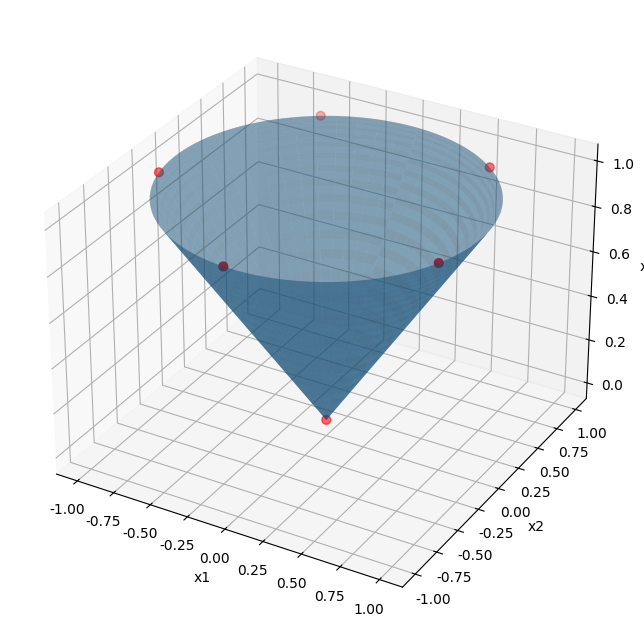

In [16]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds = (-1,1)),
        ContinuousInput(key="x2", bounds = (-1,1)),
        ContinuousInput(key="x3", bounds = (0,1))],
    outputs=[ContinuousOutput(key="y")],
    constraints=[NonlinearInequalityConstraint(expression="(x1**2 + x2**2)**0.5 - x3", features=["x1","x2","x3"])],
)

result = find_local_max_ipopt(domain, "linear", ipopt_options={"maxiter": 100, "disp":0})
result.round(3)
plot_results_3d(result, surface_func=lambda x1, x2: np.sqrt(x1**2 + x2**2))

And the same for a design space limited by an elliptical cone $x_1^2 + x_2^2 - x_3 \leq 0$.


/Users/aaron/Documents/bofire/bofire/strategies/doe/design.py:408: UserWarning: Nonlinear constraints were detected. Not all features and checks are supported for this type of constraints.                 Using them can lead to unexpected behaviour. Please make sure to provide jacobians for nonlinear constraints.
  warnings.warn(
/Users/aaron/Documents/bofire/bofire/strategies/doe/design.py:440: UserWarning: Sampling failed. Falling back to uniform sampling on input domain.                          Providing a custom sampling strategy compatible with the problem can                           possibly improve performance.
  warnings.warn(


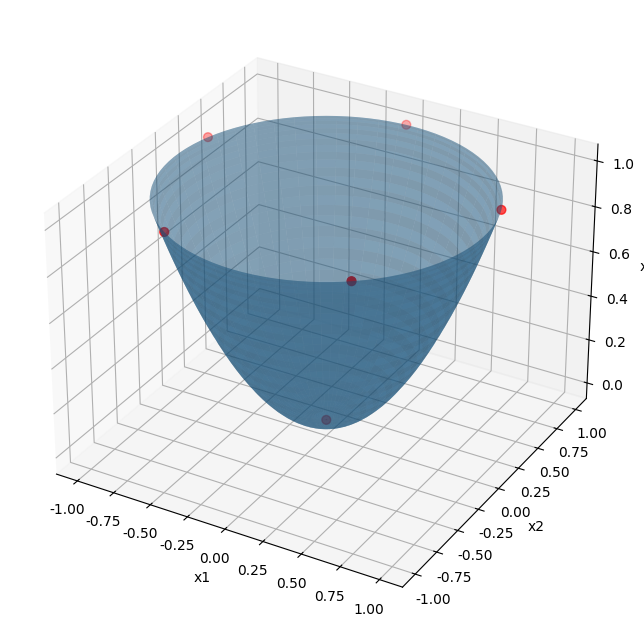

In [17]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds = (-1,1)),
        ContinuousInput(key="x2", bounds = (-1,1)),
        ContinuousInput(key="x3", bounds = (0,1))],
    outputs=[ContinuousOutput(key="y")],
    constraints=[NonlinearInequalityConstraint(expression="x1**2 + x2**2 - x3", features=["x1","x2","x3"])],
)

result = find_local_max_ipopt(domain, "linear", ipopt_options={"maxiter": 100})
result.round(3)
plot_results_3d(result, surface_func=lambda x1, x2: x1**2 + x2**2)

### Example 2: Design on the surface of a cone / nonlinear equality

We can also limit the design space to the surface of a cone, defined by the equality constraint $\sqrt{x_1^2 + x_2^2} - x_3 = 0$

Note that due to missing sampling methods in opti, the initial points provided to IPOPT don't satisfy the constraints.


/Users/aaron/Documents/bofire/bofire/strategies/doe/design.py:408: UserWarning: Nonlinear constraints were detected. Not all features and checks are supported for this type of constraints.                 Using them can lead to unexpected behaviour. Please make sure to provide jacobians for nonlinear constraints.
  warnings.warn(
/Users/aaron/Documents/bofire/bofire/strategies/doe/design.py:440: UserWarning: Sampling failed. Falling back to uniform sampling on input domain.                          Providing a custom sampling strategy compatible with the problem can                           possibly improve performance.
  warnings.warn(


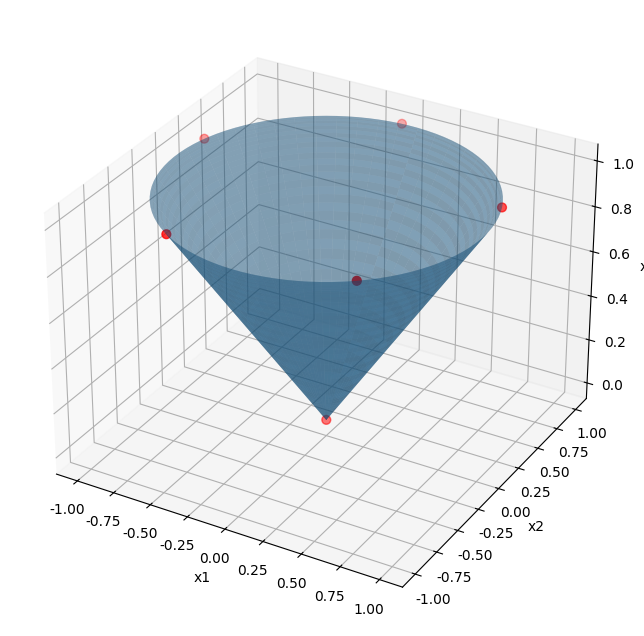

In [18]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds = (-1,1)),
        ContinuousInput(key="x2", bounds = (-1,1)),
        ContinuousInput(key="x3", bounds = (0,1))],
    outputs=[ContinuousOutput(key="y")],
    constraints=[NonlinearEqualityConstraint(expression="(x1**2 + x2**2)**0.5 - x3", features=["x1","x2","x3"])],
)

result = find_local_max_ipopt(domain, "linear", ipopt_options={"maxiter": 100})
result.round(3)
plot_results_3d(result, surface_func=lambda x1, x2: np.sqrt(x1**2 + x2**2))

### Example 3: Batch constraints
Batch constraints can be used to create designs where each set of `multiplicity` subsequent experiments have the same value for a certain feature. In the following example we fix the value of the decision variable `x1` inside each batch of size 3.   

In [19]:
domain = Domain(
    inputs=[
        ContinuousInput(key="x1", bounds = (0,1)),
        ContinuousInput(key="x2", bounds = (0,1)),
        ContinuousInput(key="x3", bounds = (0,1))],
    outputs=[ContinuousOutput(key="y")],
    constraints=[InterpointEqualityConstraint(feature="x1", multiplicity=3)]
)

result = find_local_max_ipopt(domain, "linear", ipopt_options={"maxiter": 100}, n_experiments=12)
result.round(3)

x1   x2   x3
exp0   1.0  1.0  1.0
exp1   1.0  1.0  1.0
exp2   1.0 -0.0 -0.0
exp3  -0.0  1.0  1.0
exp4  -0.0 -0.0 -0.0
exp5  -0.0 -0.0 -0.0
exp6  -0.0  1.0 -0.0
exp7  -0.0 -0.0  1.0
exp8  -0.0 -0.0  1.0
exp9  -0.0 -0.0  1.0
exp10 -0.0  1.0 -0.0